               Timestamp     Price       Diff   StdPrice    StdHigh  \
3886 2023-07-20 21:20:00  29784.62  48.873916  18.071254  10.797261   
2962 2023-07-20 05:56:00  30160.96  83.184838  25.912744  21.100050   
5056 2023-07-21 16:50:00  29836.39   5.026792   7.447483   5.769676   
214  2023-07-18 08:08:00  29968.74  -3.606481  17.315466  15.093937   
577  2023-07-18 14:11:00  29874.74  38.879767  30.953302  16.953450   
...                  ...       ...        ...        ...        ...   
2334 2023-07-19 19:28:00  30067.69  21.174459  16.539118  17.527730   
4791 2023-07-21 12:25:00  29841.03  36.813628  10.669227   8.830755   
5862 2023-07-22 06:16:00  29862.35 -10.452368   6.223296   4.095769   
1152 2023-07-18 23:46:00  29811.65 -25.502514  12.701898  20.819474   
1697 2023-07-19 08:51:00  29925.40 -85.714661  26.864614  32.577897   

         StdLow  Probability_Price_Up  Probability_Price_Down  
3886   9.949726                  1.00                    0.00  
2962  13.290757    

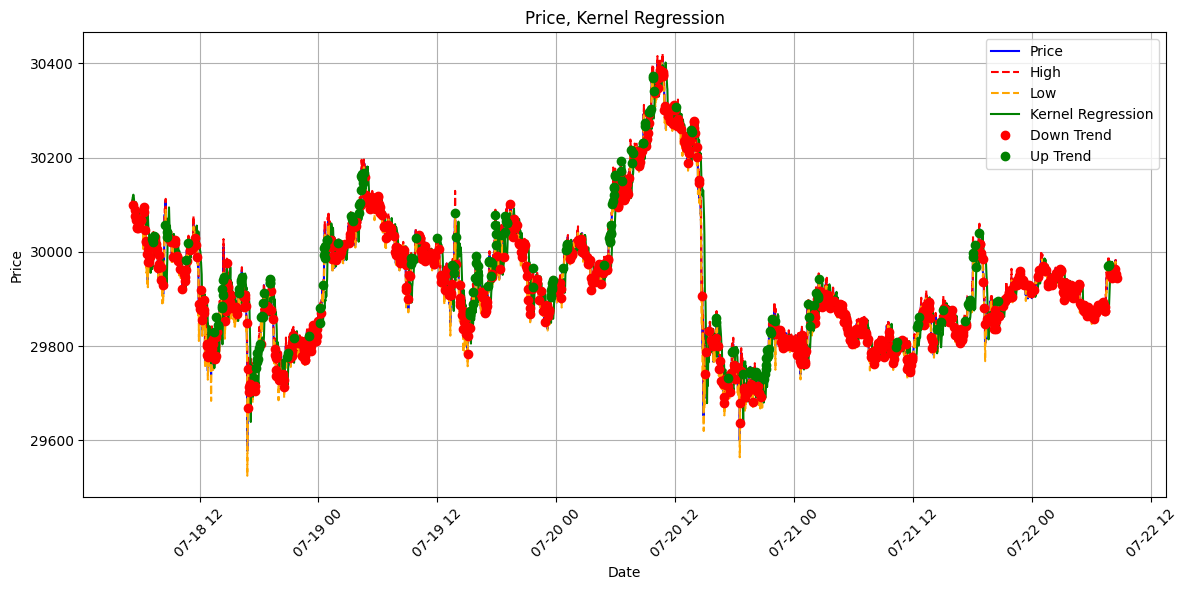

In [1]:
import requests
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score
import time
def get_last_3000_bitcoin_data():
    # Cryptowatch API endpoint for Bitcoin 1-minute data
    base_url = "https://api.cryptowat.ch/markets/coinbase-pro/btcusd/ohlc"
    # Retrieve The Last 3000 data points
    num_data_points = 6000
    # Parameters for the API call in order to retrieve 1 minute data
    params = {
        "periods": 60,  # 1 minute granularity
        "after": int(time.time()) - (60 * num_data_points),  # Timestamp of 3000 minutes ago
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Check for any errors in the API response
        data = response.json()["result"]["60"]
        # Extract the data for Timestamp, Price (closing), High, and Low
        data_points = []
        for point in data:
            timestamp = pd.to_datetime(point[0], unit='s')
            price_usd = point[4]
            high_usd = point[2]
            low_usd = point[3]
            data_points.append([timestamp, price_usd, high_usd, low_usd])
        df = pd.DataFrame(data_points, columns=["Timestamp", "Price", "High", "Low"])
        return df
    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None
if __name__ == "__main__":
    bitcoin_data = get_last_3000_bitcoin_data()
    if not bitcoin_data.empty:  # Check if the DataFrame is not empty
        data_points = []
        for _, row in bitcoin_data.iterrows():  # Iterate over rows of the DataFrame
            timestamp = row["Timestamp"]
            price_usd = row["Price"]
            high_usd = row["High"]  # Add the "High" column
            low_usd = row["Low"]  # Add the "Low" column
            data_points.append([timestamp, price_usd, high_usd, low_usd])
        df = pd.DataFrame(data_points, columns=["Timestamp", "Price", "High", "Low"])
        # Perform Nadaraya-Watson Kernel Regression for each row
        lookback_range = 20
        weighting = 0.70
        regression_level = 1
        lag_factor = 2
        regression_values = []
        for i, row in df.iterrows():
            y = df['Price'].values
            # Calculate kernel weights using KernelDensity
            weights = np.exp(-np.arange(lookback_range) * weighting)
            weights /= np.sum(weights)
            # Apply convolution to calculate predicted values utilizing the look back range
            predicted_values = np.convolve(y, weights[::-1], mode='valid')
            predicted_values = np.pad(predicted_values, (lookback_range - 1, 0), mode='constant', constant_values=np.nan)
            # Apply lag factor
            lag_values = np.concatenate((np.full(int(lag_factor), np.nan), predicted_values[:-int(lag_factor)]))
            #Apply Regression Level
            predicted_values = lag_values * regression_level
            # Get the regression value for the current row
            regression_value = predicted_values[i]
            regression_values.append(regression_value)
        # Add regression values to the dataframe
        df['KernelRegression'] = regression_values
        #Drop na's again
        df = df.dropna(axis=0)
        df['Diff'] = df['Price'] - df['KernelRegression']
        df['HighDiff'] = df['High'] - df['KernelRegression']
        df['LowDiff'] = df['Low'] - df['KernelRegression']
        # Calculate rolling standard deviations for each price column and the Kernel Regression respectively
        df['StdPrice'] = df['Price'].rolling(lookback_range).std()
        df['StdHigh'] = df['HighDiff'].rolling(lookback_range).std()
        df['StdLow'] = df['LowDiff'].rolling(lookback_range).std()
        # Drop Na's again
        df = df.dropna(axis=0)

        # Convert the target variable to binary labels (1 for price going up, 0 for price going down)
        threshold = 30  # Adjust the threshold however required
        df['Target'] = (df['Diff'] > threshold).astype(int)
        # Select features and target variable
        features = df[['Diff','HighDiff', 'LowDiff', 'StdPrice', 'StdHigh', 'StdLow']]
        target = df['Target']
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=96)
        # Scale that Data!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train an SVM classifier to generate probability estimations based upon the likelihood of movement when the difference between the closing price of bitcoin and the kernel regression equals 20
        svm_classifier = SVC(probability=True)  # Use probability=True to get probability estimates
        svm_classifier.fit(X_train_scaled, y_train)
        # Predict probabilities for the test set
        test_probabilities = svm_classifier.predict_proba(X_test_scaled)
        # Add the probabilities to the DataFrame and scale to the valid range
        df_test = df.loc[X_test.index].copy()
        df_test['Probability_Price_Up'] = test_probabilities[:, 1]  # Probability of price going up
        df_test['Probability_Price_Up'] = np.round(df_test['Probability_Price_Up'], 2)  # Round to 2 decimal places
        df_test['Probability_Price_Down'] = 1 - df_test['Probability_Price_Up']  # Probability of price going down
        df_test['Probability_Price_Down'] = np.clip(df_test['Probability_Price_Down'], 0.0, 0.99)  # Clip to be 0.99 or lower
        print(df_test[['Timestamp', 'Price', 'Diff', 'StdPrice', 'StdHigh', 'StdLow', 'Probability_Price_Up', 'Probability_Price_Down']])
        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, test_probabilities[:, 1])
        print("Mean Absolute Error of Probability Estimates (MAE):", mae)

        # Calculate Mean Squared Error (MSE) - To compute MASE
        mse = mean_squared_error(y_test, test_probabilities[:, 1])
        # Calculate Mean Absolute Squared Error (MASE)
        mase = mse / np.mean((y_test - np.mean(y_train)) ** 2)
        print("Mean Absolute Squared Error of Probability Estimates (MASE):", mase)

        # Calculate Area Under the Receiver Operating Characteristic Curve (AUC)
        auc = roc_auc_score(y_test, test_probabilities[:, 1])
        print("Area Under the Curve of Probability Estimates (AUC):", auc)
        #Calculate K-Fold Cross Validation
        k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=k_fold, scoring='roc_auc')
        print("Cross-validation scores:", cv_scores)
        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        print("Root Mean Squared Error (RMSE):", rmse)
        # Convert probabilities to binary predictions (1 for price going up, 0 for price going down)
        test_predictions = np.round(test_probabilities[:, 1])
        # Calculate Accuracy
        accuracy = accuracy_score(y_test, test_predictions)
        print("Accuracy of Probability Estimates :", accuracy)
        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(df['Timestamp'], df['Price'], label='Price', color='blue')
        plt.plot(df['Timestamp'], df['High'], label='High', color='red', linestyle='dashed')
        plt.plot(df['Timestamp'], df['Low'], label='Low', color='orange', linestyle='dashed')
        plt.plot(df['Timestamp'], df['KernelRegression'], label='Kernel Regression', color='green')
        # Add red and green dots based on the new probability conditions
        green_dots = df_test[df_test['Probability_Price_Up'] >= 0.99]
        red_dots = df_test[df_test['Probability_Price_Down'] >= 0.99]
        plt.plot(red_dots['Timestamp'], red_dots['Price'], 'ro', label='Down Trend')
        plt.plot(green_dots['Timestamp'], green_dots['Price'], 'go', label='Up Trend')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Price, Kernel Regression')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

LETS TALK ABOUT THE MODEL EVALUATION RESULTS OF THE PROBABILITY ESTIMATIONS FOR UPWARD AND DOWNWARD PRICE MOVEMENTS. OUR GOAL OBVIOUSLY BEING TO BUILD A MODEL THAT UTILIZES THE RELATIONSHIP BETWEEN THE PRICE AND KERNEL REGRESSION, IN ORDER TO GENERATE PROBABILITY ESTIMATIONS THAT INDICATE THE PROBABILITY THAT THE PRICE WILL INCREASE OR DECREASE BY AT LEAST 30 DOLLARS IN THE NEXT MINUTE. 

The MAE measures the average difference between the predicted probabilities and the actual target probabilities. A smaller MAE indicates that the model's probability predictions are closer to the true probabilities. In this case, the MAE value of approximately 0.0161 (1.6%) means that, on average, the model's probability estimates deviate by about 1.6% from the true probabilities.

The MASE is a scaled version of the mean squared error of the probability predictions, comparing it to a naive baseline model. A lower MASE value (0.045 in this case) indicates that the model's probability predictions are better than a simple baseline model. It suggests that the model is providing relatively accurate probability estimates where while SCALED under normalization theory, it is accurate with up to a 4.5% error rate. Mathematically it can be said that any machine or deep learning model with an MASE of less than 40% should be stated as MORE effective than the Naive model.

The AUC represents the overall ability of the model to discriminate between positive and negative instances based on the predicted probabilities. A value of 0.999, which is very close to 1, indicates that the model has an excellent ability to distinguish between price movements going up and down. The closer to 1, the better the model's discrimination power.

The cross-validation scores (0.99877108 0.99913546, 0.99941745, 0.9993, 0.9991) are AUC values obtained from performing k-fold cross-validation (with k=5). These high AUC values consistently suggest that the model is robust and maintains excellent performance across different data splits. It indicates the model's ability to generalize well to new, unseen data.

The RMSE measures the average difference between the predicted probabilities and the actual target probabilities, considering the squared differences. A smaller RMSE value (0.0866 in this case) means that the model's probability estimates are generally close to the true probabilities with JUST an 8.6% deviation even while being CONSERVATIVE and as unbias as we can be when assessing the differences between predictions and true values. It indicates good precision in probability predictions.
The accuracy of probability estimates (0.9907) represents the percentage of correct predictions made by the model. It indicates that the model's probability estimates match the actual price movements with high accuracy. An accuracy of 0.9907 suggests that the model's predictions align well with the true probabilities of the price going up or down

In [2]:
print(df_test['Probability_Price_Down'].unique())
print(df_test['Probability_Price_Up'].unique())

[0.   0.99 0.1  0.02 0.01 0.05 0.28 0.18 0.31 0.44 0.83 0.04 0.06 0.81
 0.79 0.35 0.33 0.95 0.11 0.98 0.86 0.84 0.94 0.41 0.4  0.29 0.57 0.56
 0.96 0.14 0.58 0.07 0.97 0.9  0.92 0.39 0.53 0.12 0.3  0.03 0.55 0.32
 0.16 0.65 0.66 0.61 0.64 0.5  0.54]
[1.   0.   0.9  0.98 0.01 0.99 0.95 0.72 0.82 0.69 0.56 0.17 0.96 0.94
 0.19 0.21 0.65 0.67 0.05 0.89 0.02 0.14 0.16 0.06 0.59 0.6  0.71 0.43
 0.44 0.04 0.86 0.42 0.93 0.03 0.1  0.08 0.61 0.47 0.88 0.7  0.97 0.45
 0.68 0.84 0.35 0.34 0.39 0.36 0.5  0.46]
